In [1]:
import json
import pandas as pd
import matplotlib.pyplot as plt
import math

In [2]:
# Specify the path to your JSON file
file_path = 'data/ALL2024.json'


In [3]:
def load_boat_data(file_path):
    """
    Load boat data from a JSON file.
    :param file_path: Path to the file containing boat data.
    :return: List of boat data dictionaries.
    """
    with open(file_path, 'r') as file:
        return json.load(file)


In [4]:

data = load_boat_data(file_path=file_path)

In [5]:
data[3560]

{'sailnumber': 'FIN/FIN9858',
 'country': 'FIN',
 'name': 'Merinna',
 'rating': {'gph': 680.9,
  'osn': 660.5,
  'triple_offshore': [0.7734, 0.9938, 1.1033],
  'triple_inshore': [0.6028, 0.814, 0.9335]},
 'boat': {'builder': 'Elan Marine',
  'type': 'Elan 31',
  'designer': 'Humpreys',
  'year': 2002,
  'sizes': {'loa': 9.19,
   'beam': 3.2,
   'draft': 1.9,
   'displacement': 4378.0,
   'genoa': 27.07,
   'main': 29.21,
   'spinnaker': 56.24,
   'spinnaker_asym': 0.0,
   'crew': 450.0,
   'wetted_surface': 21.21}},
 'vpp': {'angles': [52, 60, 75, 90, 110, 120, 135, 150],
  'speeds': [6, 8, 10, 12, 14, 16, 20, 24],
  '52': [4.97, 5.8, 6.3, 6.54, 6.65, 6.71, 6.77, 6.77],
  '60': [5.21, 6.02, 6.46, 6.69, 6.82, 6.89, 6.97, 6.99],
  '75': [5.36, 6.17, 6.59, 6.84, 7.02, 7.15, 7.29, 7.38],
  '90': [5.25, 6.12, 6.63, 6.91, 7.11, 7.31, 7.59, 7.76],
  '110': [5.13, 6.15, 6.72, 7.06, 7.35, 7.6, 7.9, 8.12],
  '120': [4.95, 5.99, 6.63, 7.0, 7.31, 7.61, 8.16, 8.52],
  '135': [4.44, 5.47, 6.26, 6.75

In [6]:
def filter_boats(boats, sailnumber=None, name=None,builder=None, boat_type=None):
    """
    Filter boats by sailnumber, builder, and/or type with case-insensitive partial matching.
    Returns full dictionaries of matching boats.
    :param boats: List of boat dictionaries.
    :param sailnumber: Partial sailnumber to filter by (case-insensitive).
    :param name: Partial name to filter by (case-insensitive).
    :param builder: Partial builder name to filter by (case-insensitive).
    :param boat_type: Partial boat type to filter by (case-insensitive).
    :return: List of dictionaries representing the matching boats.
    """
    def matches(field, keyword):
        """Helper function to check if a field matches the keyword (case-insensitive partial match)."""
        if not field or not keyword:  # Ignore None fields or empty keywords
            return False
        return keyword.lower() in field.lower()

    # Apply filters
    return [
        boat for boat in boats
        if (not sailnumber or matches(boat.get('sailnumber', ''), sailnumber)) and
           (not name or matches(boat.get('name', ''), name)) and
           (not builder or matches(boat.get('boat', {}).get('builder', ''), builder)) and
           (not boat_type or matches(boat.get('boat', {}).get('type', ''), boat_type))
    ]


In [7]:
def get_boat_index_by_sailnumber(boats, sailnumber):
    """
    Return the index of a boat with the given sailnumber (without an explicit loop).
    :param boats: List of boat dictionaries.
    :param sailnumber: Sailnumber to search for (exact match).
    :return: Index of the boat or None if not found.
    """
    return next((index for index, boat in enumerate(boats) if boat.get('sailnumber') == sailnumber), None)


In [8]:
def get_polar_data(boat):
    """
    Extract polar data from a boat dictionary, including extended VMG data with beat and run extremes.
    :param boat: Dictionary containing boat data.
    :return: Dictionary with extended polar data.
    """
    vpp = boat.get('vpp', {})
    
    if not vpp:
        return None  # No VPP data available

    # Extract base polar data
    base_angles = vpp.get('angles', [])
    base_speeds = vpp.get('speeds', [])
    base_data = {angle: vpp.get(str(angle), []) for angle in base_angles}
    max_base_angle = max(base_angles)

    # Extract beat and run extremes
    beat_angles = vpp.get('beat_angle', [])
    beat_vmgs = vpp.get('beat_vmg', [])
    beat_speeds = [vmg / math.cos(math.radians(twa)) for vmg,twa in zip(beat_vmgs,beat_angles)]
    run_angles = vpp.get('run_angle', [])
    run_vmgs = vpp.get('run_vmg', [])
    run_speeds = [vmg / math.cos(math.radians(180 - twa)) for vmg,twa in zip(run_vmgs,run_angles)]

    # Extend VMG lines with extremes
    extended_vmg_lines = {}
    for i, wind_speed in enumerate(base_speeds):
        # Create a unified VMG line for this wind speed
        beat_point = (beat_angles[i], beat_speeds[i]) if i < len(beat_angles) else None
        run_point = (run_angles[i], run_speeds[i]) if i < len(run_angles)  else None
        main_points = [(angle, base_data[angle][i]) for angle in base_angles]

        # Combine points and sort by angle
        vmg_line = [p for p in [beat_point, *main_points, run_point] if p]
        extended_vmg_lines[wind_speed] = sorted(vmg_line, key=lambda x: x[0])

    return {
        'angles': base_angles,
        'speeds': base_speeds,
        'data': base_data,
        'extended_vmg': extended_vmg_lines
    }


In [9]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.interpolate import CubicSpline

def plot_half_polar_data_cubicSpline(boat, polar_data):
    """
    Plot a half-polar diagram (0-180 degrees) for a boat using extended VMG lines with cubic interpolation.
    Also plot the given data points for evaluation.
    :param boat: Dictionary containing boat data.
    :param polar_data: Dictionary containing extended polar data.
    """
    # Extract extended VMG data
    extended_vmg = polar_data.get('extended_vmg', {})
    base_speeds = polar_data.get('speeds', [])

    # Generate the title: "[sailnumber] boat builder: type"
    name = boat.get('name', 'Unknown')
    sailnumber = boat.get('sailnumber', 'Unknown')
    builder = boat.get('boat', {}).get('builder', 'Unknown Builder')
    boat_type = boat.get('boat', {}).get('type', 'Unknown Type')
    title = f"{name}\n[{sailnumber}] {builder}: {boat_type}"

    # Initialize the polar plot
    fig, ax = plt.subplots(subplot_kw={'projection': 'polar'}, figsize=(8, 6))

    # Limit the plot to 0-180 degrees
    ax.set_thetamin(0)
    ax.set_thetamax(180)

    # Plot extended VMG lines with cubic interpolation
    for wind_speed, vmg_line in extended_vmg.items():
        # Extract angles and speeds
        angles = [point[0] for point in vmg_line]
        speeds = [point[1] for point in vmg_line]

        # Interpolate the data for smoother lines
        cubic_interp = CubicSpline(angles, speeds, bc_type='natural')
        interpolated_angles = np.linspace(min(angles), max(angles), 500)
        interpolated_speeds = cubic_interp(interpolated_angles)

        # Convert interpolated angles to radians
        interpolated_angles_rad = np.radians(interpolated_angles)

        # Plot the interpolated line
        ax.plot(interpolated_angles_rad, interpolated_speeds, label=f"{wind_speed} knots")

        # Plot the given data points
        angles_rad = np.radians(angles)  # Convert angles to radians
        ax.scatter(angles_rad, speeds, s=20, marker='o', color=ax.get_lines()[-1].get_color())
        # ax.scatter(angles_rad, speeds, label=f"{wind_speed} knots (data)", s=20, marker='o')

    # Configure radial axis
    max_boat_speed = max(max([point[1] for point in vmg_line]) for vmg_line in extended_vmg.values())
    radial_ticks = np.arange(0, max_boat_speed + 2, 2)  # Circles every 2 knots
    ax.set_rmax(max_boat_speed)  # Set max radius to the maximum boat speed
    ax.set_rticks(radial_ticks)  # Set radial ticks to achieved boat speed values
    ax.set_rlabel_position(90)  # Place radial labels at the center
    ax.set_rgrids(radial_ticks, labels=[f"{v} kn" for v in radial_ticks])  # Label radial grids with boat speeds

    # Configure the plot
    ax.set_theta_zero_location("N")
    ax.set_theta_direction(-1)  # Clockwise direction
    ax.set_title(title, va='bottom', pad=20)
    ax.legend(loc='upper right', bbox_to_anchor=(1.3, 1.0))

    # Show the plot
    plt.show()


In [10]:
from scipy.interpolate import UnivariateSpline

def plot_half_polar_data_with_smoothing(boat, polar_data, smoothing_factor=0.1):
    """
    Plot a half-polar diagram (0-180 degrees) for a boat using extended VMG lines with smoothing splines.
    Also plot the given data points for evaluation.
    :param boat: Dictionary containing boat data.
    :param polar_data: Dictionary containing extended polar data.
    :param smoothing_factor: Smoothing factor for the spline interpolation.
    """
    # Extract extended VMG data
    extended_vmg = polar_data.get('extended_vmg', {})
    base_speeds = polar_data.get('speeds', [])

    # Generate the title: "[sailnumber] boat builder: type"
    sailnumber = boat.get('sailnumber', 'Unknown')
    builder = boat.get('boat', {}).get('builder', 'Unknown Builder')
    boat_type = boat.get('boat', {}).get('type', 'Unknown Type')
    title = f"[{sailnumber}] {builder}: {boat_type}"

    # Initialize the polar plot
    fig, ax = plt.subplots(subplot_kw={'projection': 'polar'}, figsize=(8, 6))

    # Limit the plot to 0-180 degrees
    ax.set_thetamin(0)
    ax.set_thetamax(180)

    # Plot extended VMG lines with smoothing splines
    for wind_speed, vmg_line in extended_vmg.items():
        # Extract angles and speeds
        angles = [point[0] for point in vmg_line]
        speeds = [point[1] for point in vmg_line]

        # Apply smoothing spline
        smoothing_spline = UnivariateSpline(angles, speeds, s=smoothing_factor)
        interpolated_angles = np.linspace(min(angles), max(angles), 500)
        interpolated_speeds = smoothing_spline(interpolated_angles)

        # Convert interpolated angles to radians
        interpolated_angles_rad = np.radians(interpolated_angles)

        # Plot the smoothed line
        ax.plot(interpolated_angles_rad, interpolated_speeds, label=f"{wind_speed} knots")

        # Plot the given data points
        angles_rad = np.radians(angles)  # Convert angles to radians
        ax.scatter(angles_rad, speeds, s=20, marker='o', color=ax.get_lines()[-1].get_color())
        # ax.scatter(angles_rad, speeds, label=f"{wind_speed} knots (data)", s=20, marker='o')

    # Configure radial axis
    max_boat_speed = max(max([point[1] for point in vmg_line]) for vmg_line in extended_vmg.values())
    radial_ticks = np.arange(0, max_boat_speed + 2, 2)  # Circles every 2 knots
    ax.set_rmax(max_boat_speed)  # Set max radius to the maximum boat speed
    ax.set_rticks(radial_ticks)  # Set radial ticks to achieved boat speed values
    ax.set_rlabel_position(90)  # Place radial labels at the center
    ax.set_rgrids(radial_ticks, labels=[f"{v} kn" for v in radial_ticks])  # Label radial grids with boat speeds

    # Configure the plot
    ax.set_theta_zero_location("N")
    ax.set_theta_direction(-1)  # Clockwise direction
    ax.set_title(title, va='bottom', pad=20)
    ax.legend(loc='upper right', bbox_to_anchor=(1.3, 1.0))

    # Show the plot
    plt.show()


In [11]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.interpolate import CubicSpline

def plot_half_polar_data_cubicSpline_with_vmg(boat, polar_data):
    """
    Plot a half-polar diagram (0-180 degrees) for a boat using extended VMG lines with cubic interpolation.
    Include horizontal tangents at the beat and run angles for each TWS and annotate VMG values.
    :param boat: Dictionary containing boat data.
    :param polar_data: Dictionary containing extended polar data.
    """
    # Extract extended VMG data
    extended_vmg = polar_data.get('extended_vmg', {})
    base_speeds = polar_data.get('speeds', [])
    beat_angles = polar_data.get('beat_angle', [])
    beat_vmgs = polar_data.get('beat_vmg', [])
    run_angles = polar_data.get('run_angle', [])
    run_vmgs = polar_data.get('run_vmg', [])

    # Generate the title: Bold name and details
    name = boat.get('name', 'Unknown')
    sailnumber = boat.get('sailnumber', 'Unknown')
    builder = boat.get('boat', {}).get('builder', 'Unknown Builder')
    boat_type = boat.get('boat', {}).get('type', 'Unknown Type')
    title = f"$\\bf{{{name}}}$\n[{sailnumber}] {builder}: {boat_type}"

    # Initialize the polar plot
    fig, ax = plt.subplots(subplot_kw={'projection': 'polar'}, figsize=(8, 6))

    # Limit the plot to 0-180 degrees
    ax.set_thetamin(0)
    ax.set_thetamax(180)

    # Plot extended VMG lines with cubic interpolation
    for i, (wind_speed, vmg_line) in enumerate(extended_vmg.items()):
        # Extract angles and speeds
        angles = [point[0] for point in vmg_line]
        speeds = [point[1] for point in vmg_line]

        # Interpolate the data for smoother lines
        cubic_interp = CubicSpline(angles, speeds, bc_type='natural')
        interpolated_angles = np.linspace(min(angles), max(angles), 500)
        interpolated_speeds = cubic_interp(interpolated_angles)

        # Convert interpolated angles to radians
        interpolated_angles_rad = np.radians(interpolated_angles)

        # Plot the interpolated line
        ax.plot(interpolated_angles_rad, interpolated_speeds, label=f"{wind_speed} knots")

        # Plot the given data points
        angles_rad = np.radians(angles)  # Convert angles to radians
        ax.scatter(angles_rad, speeds, s=20, marker='o', color=ax.get_lines()[-1].get_color())

        # Plot horizontal tangent lines at beat and run angles
        if i < len(beat_angles) and i < len(run_angles):
            beat_angle = beat_angles[i]
            beat_vmg = beat_vmgs[i]
            run_angle = run_angles[i]
            run_vmg = run_vmgs[i]

            # Horizontal tangent lines
            ax.plot([np.radians(beat_angle), np.radians(beat_angle)], [0, beat_vmg],
                    linestyle='--', color='blue', label=f"Beat VMG ({wind_speed} kn)")
            ax.plot([np.radians(run_angle), np.radians(run_angle)], [0, run_vmg],
                    linestyle='--', color='red', label=f"Run VMG ({wind_speed} kn)")

            # Annotate the VMG values
            ax.annotate(f"{beat_vmg:.2f} kn",
                        xy=(np.radians(beat_angle), beat_vmg),
                        xytext=(np.radians(beat_angle) + 0.1, beat_vmg + 0.5),
                        arrowprops=dict(arrowstyle="->", color='blue'),
                        color='blue')
            ax.annotate(f"{run_vmg:.2f} kn",
                        xy=(np.radians(run_angle), run_vmg),
                        xytext=(np.radians(run_angle) + 0.1, run_vmg + 0.5),
                        arrowprops=dict(arrowstyle="->", color='red'),
                        color='red')

    # Configure radial axis
    max_boat_speed = max(max([point[1] for point in vmg_line]) for vmg_line in extended_vmg.values())
    radial_ticks = np.arange(0, max_boat_speed + 2, 2)  # Circles every 2 knots
    ax.set_rmax(max_boat_speed)  # Set max radius to the maximum boat speed
    ax.set_rticks(radial_ticks)  # Set radial ticks to achieved boat speed values
    ax.set_rlabel_position(90)  # Place radial labels at the center
    ax.set_rgrids(radial_ticks, labels=[f"{v} kn" for v in radial_ticks])  # Label radial grids with boat speeds

    # Configure the plot
    ax.set_theta_zero_location("N")
    ax.set_theta_direction(-1)  # Clockwise direction
    ax.set_title(title, va='bottom', pad=20)
    ax.legend(loc='upper right', bbox_to_anchor=(1.3, 1.0))

    # Show the plot
    plt.show()


In [12]:
from scipy.interpolate import InterpolatedUnivariateSpline

def plot_half_polar_data_with_smooth_cubic_interpolation(boat, polar_data, smoothness=1):
    """
    Plot a half-polar diagram (0-180 degrees) for a boat using cubic interpolation with adjustable smoothness.
    :param boat: Dictionary containing boat data.
    :param polar_data: Dictionary containing extended polar data.
    :param smoothness: Smoothing parameter for the UnivariateSpline.
    """
    # Extract extended VMG data
    extended_vmg = polar_data.get('extended_vmg', {})
    base_speeds = polar_data.get('speeds', [])

    # Generate the title: "[sailnumber] boat builder: type"
    sailnumber = boat.get('sailnumber', 'Unknown')
    builder = boat.get('boat', {}).get('builder', 'Unknown Builder')
    boat_type = boat.get('boat', {}).get('type', 'Unknown Type')
    title = f"[{sailnumber}] {builder}: {boat_type})"
    # Initialize the polar plot
    fig, ax = plt.subplots(subplot_kw={'projection': 'polar'}, figsize=(8, 6))

    # Limit the plot to 0-180 degrees
    ax.set_thetamin(0)
    ax.set_thetamax(180)

    # Plot extended VMG lines
    for wind_speed, vmg_line in extended_vmg.items():
        # Extract angles and speeds
        angles = [point[0] for point in vmg_line]
        speeds = [point[1] for point in vmg_line]

        # Apply smoothing spline for cubic interpolation
        smoothing_spline = InterpolatedUnivariateSpline(angles, speeds)
        interpolated_angles = np.linspace(min(angles), max(angles), 500)
        interpolated_speeds = smoothing_spline(interpolated_angles)

        # Convert interpolated angles to radians
        interpolated_angles_rad = np.radians(interpolated_angles)

        # Plot the interpolated line
        ax.plot(interpolated_angles_rad, interpolated_speeds, label=f"{wind_speed} knots")

        # Plot the given data points
        angles_rad = np.radians(angles)  # Convert angles to radians
        ax.scatter(angles_rad, speeds, s=20, marker='o', color=ax.get_lines()[-1].get_color())
        # ax.scatter(angles_rad, speeds, label=f"{wind_speed} knots (data)", s=20, marker='o')

    # Configure radial axis
    max_boat_speed = max(max([point[1] for point in vmg_line]) for vmg_line in extended_vmg.values())
    radial_ticks = np.arange(0, max_boat_speed + 2, 2)  # Circles every 2 knots
    ax.set_rmax(max_boat_speed)  # Set max radius to the maximum boat speed
    ax.set_rticks(radial_ticks)  # Set radial ticks to achieved boat speed values
    ax.set_rlabel_position(90)  # Place radial labels at the center
    ax.set_rgrids(radial_ticks, labels=[f"{v} kn" for v in radial_ticks])  # Label radial grids with boat speeds

    # Configure the plot
    ax.set_theta_zero_location("N")
    ax.set_theta_direction(-1)  # Clockwise direction
    ax.set_title(title, va='bottom', pad=20)
    ax.legend(loc='upper right') #, bbox_to_anchor=(1.3, 1.1))

    # Show the plot
    plt.show()


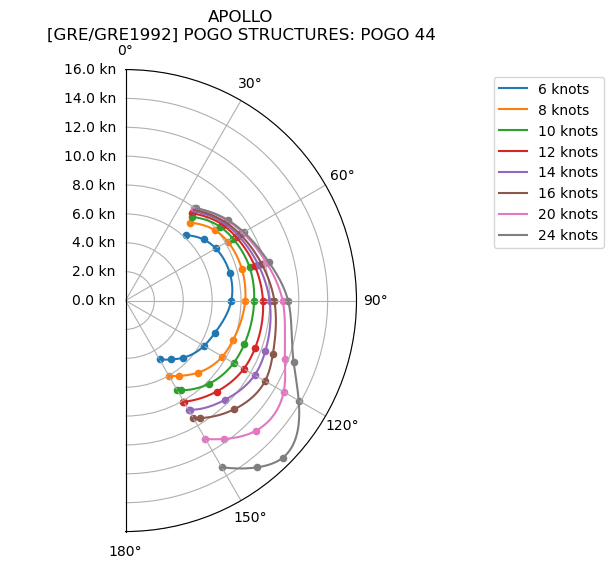

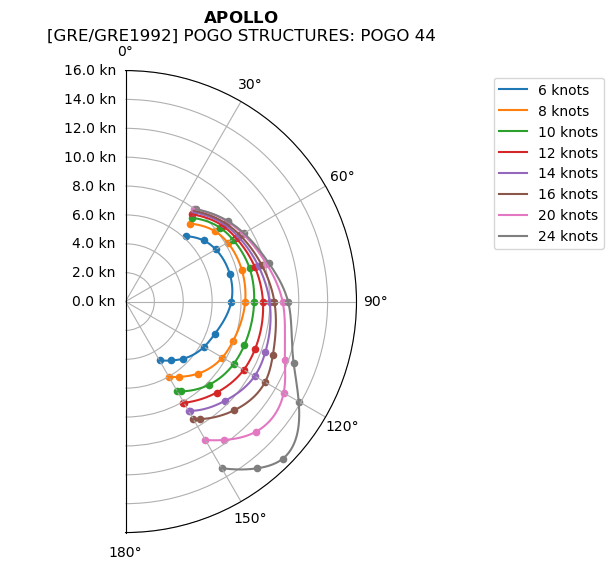

{'sailnumber': 'GRE/GRE1992',
 'country': 'GRE',
 'name': 'APOLLO',
 'rating': {'gph': 515.3,
  'osn': 501.9,
  'triple_offshore': [1.0238, 1.3071, 1.4933],
  'triple_inshore': [0.7916, 1.0468, 1.2052]},
 'boat': {'builder': 'POGO STRUCTURES',
  'type': 'POGO 44',
  'designer': 'FINOT CONQ',
  'year': 2020,
  'sizes': {'loa': 12.8,
   'beam': 4.5,
   'draft': 3.1,
   'displacement': 6295.0,
   'genoa': 82.08,
   'main': 61.12,
   'spinnaker': 0.0,
   'spinnaker_asym': 137.1,
   'crew': 970.0,
   'wetted_surface': 38.62}},
 'vpp': {'angles': [52, 60, 75, 90, 110, 120, 135, 150],
  'speeds': [6, 8, 10, 12, 14, 16, 20, 24],
  '52': [6.87, 7.89, 8.31, 8.53, 8.68, 8.8, 8.98, 9.03],
  '60': [7.22, 8.17, 8.59, 8.83, 9.01, 9.17, 9.38, 9.47],
  '75': [7.47, 8.35, 8.9, 9.27, 9.53, 9.77, 10.11, 10.28],
  '90': [7.33, 8.29, 8.91, 9.52, 9.98, 10.31, 10.88, 11.26],
  '110': [6.58, 7.94, 8.77, 9.56, 10.3, 10.86, 11.75, 12.39],
  '120': [6.28, 7.75, 8.65, 9.46, 10.33, 11.16, 12.65, 13.85],
  '135': [5

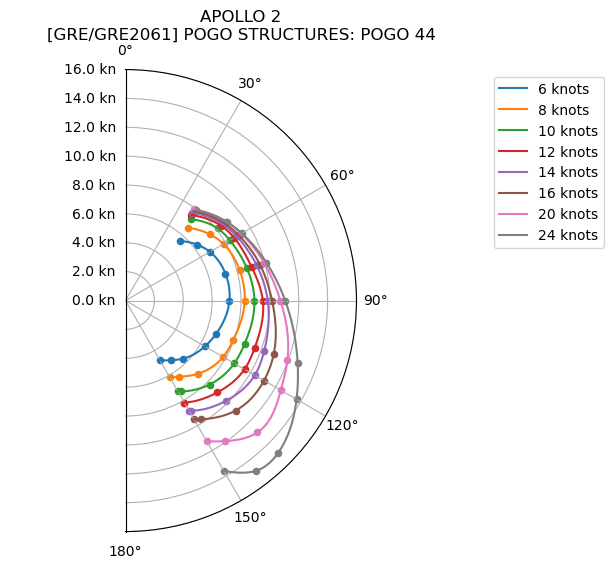

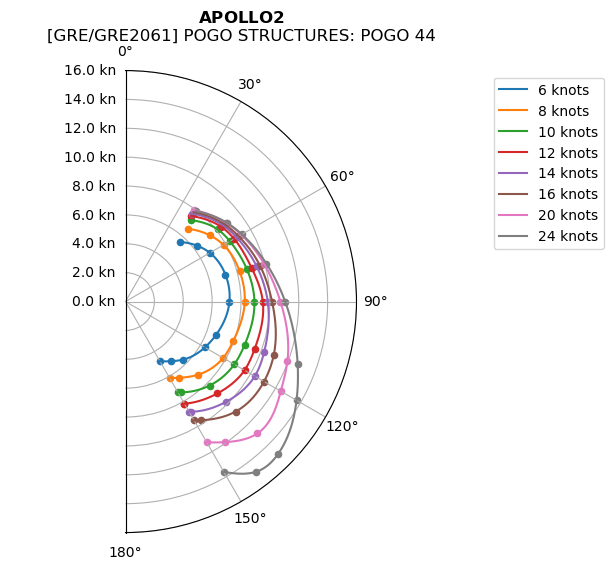

{'sailnumber': 'GRE/GRE2061',
 'country': 'GRE',
 'name': 'APOLLO 2',
 'rating': {'gph': 522.9,
  'osn': 508.0,
  'triple_offshore': [0.9957, 1.2952, 1.4853],
  'triple_inshore': [0.7653, 1.0368, 1.2005]},
 'boat': {'builder': 'POGO STRUCTURES',
  'type': 'POGO 44',
  'designer': 'FINOT CONQ',
  'year': 2020,
  'sizes': {'loa': 12.8,
   'beam': 4.5,
   'draft': 3.1,
   'displacement': 6295.0,
   'genoa': 46.08,
   'main': 61.87,
   'spinnaker': 0.0,
   'spinnaker_asym': 148.4,
   'crew': 970.0,
   'wetted_surface': 38.52}},
 'vpp': {'angles': [52, 60, 75, 90, 110, 120, 135, 150],
  'speeds': [6, 8, 10, 12, 14, 16, 20, 24],
  '52': [6.29, 7.44, 8.11, 8.41, 8.57, 8.7, 8.86, 8.88],
  '60': [6.75, 7.84, 8.35, 8.69, 8.89, 9.05, 9.26, 9.31],
  '75': [7.17, 8.18, 8.7, 9.04, 9.41, 9.64, 9.96, 10.11],
  '90': [7.2, 8.26, 8.93, 9.51, 9.85, 10.15, 10.73, 11.06],
  '110': [6.69, 7.95, 8.78, 9.53, 10.22, 10.92, 11.94, 12.69],
  '120': [6.35, 7.81, 8.7, 9.52, 10.34, 11.08, 12.42, 13.68],
  '135': [5

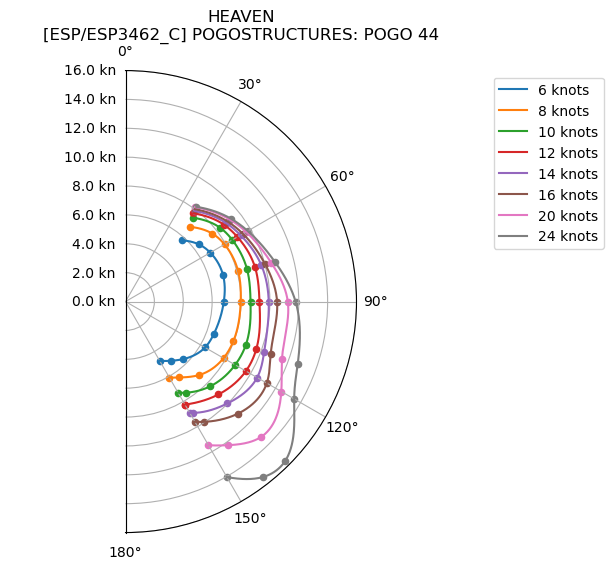

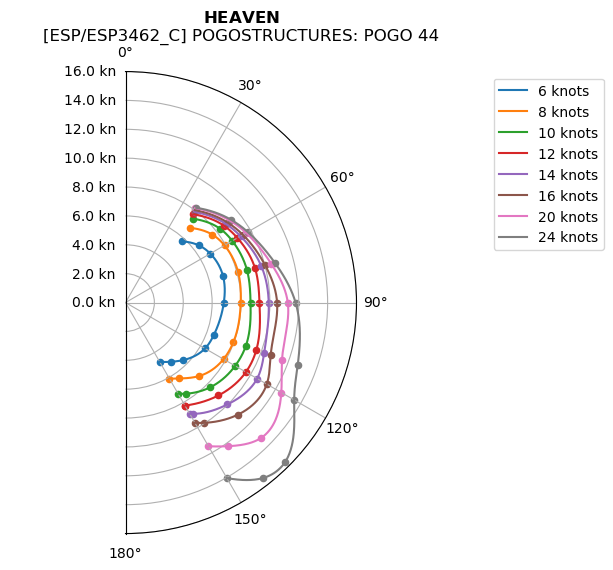

{'sailnumber': 'ESP/ESP3462_C',
 'country': 'ESP',
 'name': 'HEAVEN',
 'rating': {'gph': 517.0,
  'osn': 499.9,
  'triple_offshore': [0.9976, 1.314, 1.521],
  'triple_inshore': [0.7729, 1.056, 1.2306]},
 'boat': {'builder': 'POGOSTRUCTURES',
  'type': 'POGO 44',
  'designer': 'FINOT CONQ',
  'year': 2020,
  'sizes': {'loa': 12.8,
   'beam': 4.5,
   'draft': 3.09,
   'displacement': 6187.0,
   'genoa': 67.81,
   'main': 53.23,
   'spinnaker': 0.0,
   'spinnaker_asym': 177.12,
   'crew': 972.0,
   'wetted_surface': 38.52}},
 'vpp': {'angles': [52, 60, 75, 90, 110, 120, 135, 150],
  'speeds': [6, 8, 10, 12, 14, 16, 20, 24],
  '52': [6.44, 7.64, 8.31, 8.65, 8.84, 8.99, 9.2, 9.3],
  '60': [6.78, 7.92, 8.54, 8.95, 9.2, 9.39, 9.65, 9.78],
  '75': [7.0, 8.08, 8.71, 9.28, 9.74, 10.01, 10.44, 10.7],
  '90': [6.81, 7.98, 8.66, 9.28, 9.92, 10.5, 11.24, 11.78],
  '110': [6.52, 7.96, 8.86, 9.64, 10.22, 10.7, 11.54, 12.69],
  '120': [6.36, 7.84, 8.77, 9.63, 10.53, 11.3, 12.46, 13.49],
  '135': [5.64,

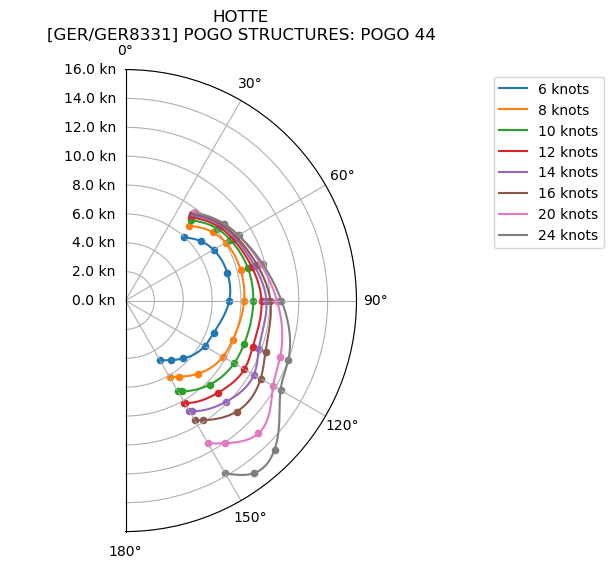

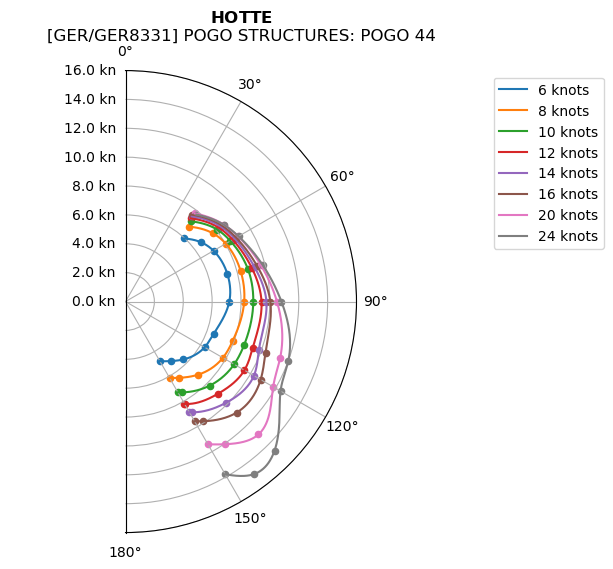

{'sailnumber': 'GER/GER8331',
 'country': 'GER',
 'name': 'HOTTE',
 'rating': {'gph': 523.9,
  'osn': 511.0,
  'triple_offshore': [1.011, 1.2847, 1.4576],
  'triple_inshore': [0.7809, 1.0268, 1.1817]},
 'boat': {'builder': 'POGO STRUCTURES',
  'type': 'POGO 44',
  'designer': 'FINOT - CONQ',
  'year': 2020,
  'sizes': {'loa': 12.8,
   'beam': 4.5,
   'draft': 3.1,
   'displacement': 6420.0,
   'genoa': 49.84,
   'main': 61.24,
   'spinnaker': 0.0,
   'spinnaker_asym': 155.69,
   'crew': 690.0,
   'wetted_surface': 38.29}},
 'vpp': {'angles': [52, 60, 75, 90, 110, 120, 135, 150],
  'speeds': [6, 8, 10, 12, 14, 16, 20, 24],
  '52': [6.66, 7.68, 8.08, 8.26, 8.41, 8.52, 8.65, 8.64],
  '60': [7.04, 8.02, 8.39, 8.57, 8.73, 8.85, 9.02, 9.04],
  '75': [7.31, 8.25, 8.77, 9.05, 9.25, 9.45, 9.71, 9.83],
  '90': [7.19, 8.22, 8.85, 9.42, 9.76, 10.03, 10.49, 10.8],
  '110': [6.51, 7.91, 8.75, 9.38, 9.83, 10.32, 11.4, 12.0],
  '120': [6.33, 7.79, 8.69, 9.51, 10.27, 10.81, 11.81, 12.4],
  '135': [5.67

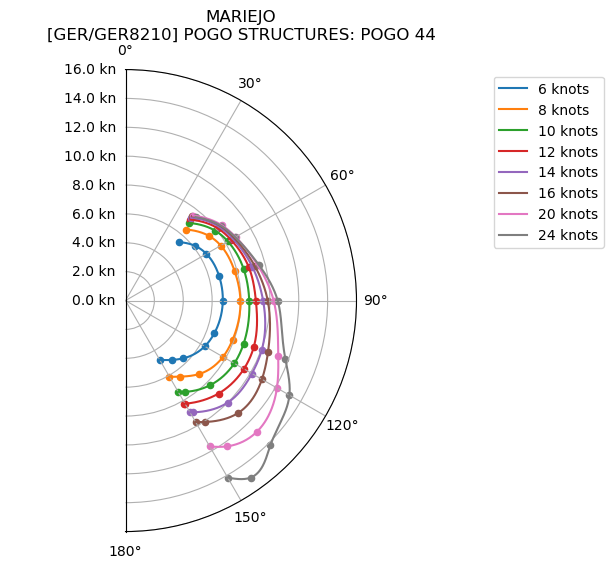

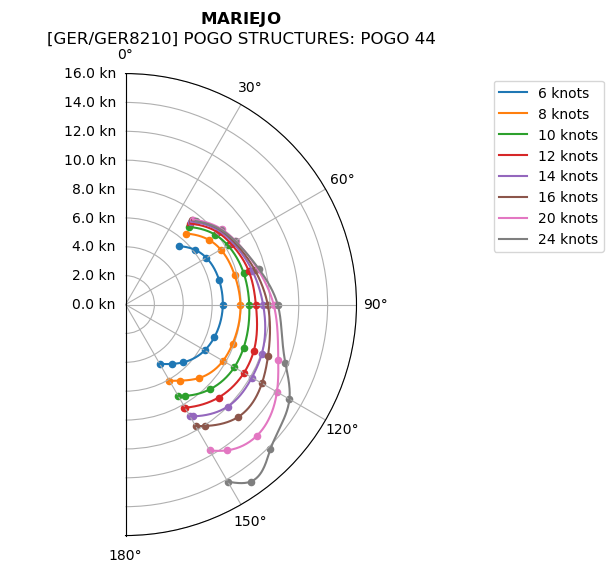

{'sailnumber': 'GER/GER8210',
 'country': 'GER',
 'name': 'MARIEJO',
 'rating': {'gph': 535.0,
  'osn': 519.7,
  'triple_offshore': [0.9762, 1.2659, 1.4415],
  'triple_inshore': [0.7547, 1.0125, 1.1687]},
 'boat': {'builder': 'POGO STRUCTURES',
  'type': 'POGO 44',
  'designer': 'FINOT-CONQ',
  'year': 2020,
  'sizes': {'loa': 12.8,
   'beam': 4.5,
   'draft': 3.1,
   'displacement': 6415.0,
   'genoa': 48.45,
   'main': 57.31,
   'spinnaker': 0.0,
   'spinnaker_asym': 168.19,
   'crew': 420.0,
   'wetted_surface': 37.82}},
 'vpp': {'angles': [52, 60, 75, 90, 110, 120, 135, 150],
  'speeds': [6, 8, 10, 12, 14, 16, 20, 24],
  '52': [6.14, 7.3, 7.87, 8.12, 8.27, 8.37, 8.47, 8.41],
  '60': [6.47, 7.62, 8.19, 8.43, 8.58, 8.69, 8.81, 8.78],
  '75': [6.7, 7.83, 8.47, 8.85, 9.09, 9.27, 9.48, 9.56],
  '90': [6.74, 7.96, 8.57, 9.03, 9.53, 9.85, 10.26, 10.54],
  '110': [6.56, 7.9, 8.71, 9.45, 10.04, 10.5, 11.26, 11.78],
  '120': [6.34, 7.8, 8.7, 9.47, 10.11, 10.91, 12.11, 13.11],
  '135': [5.66,

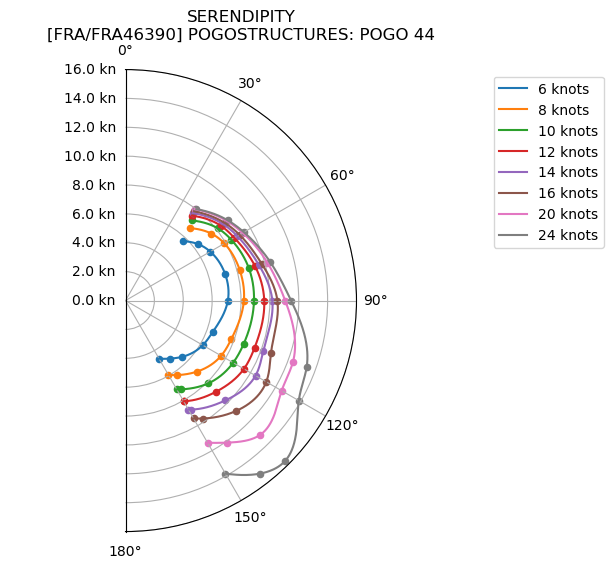

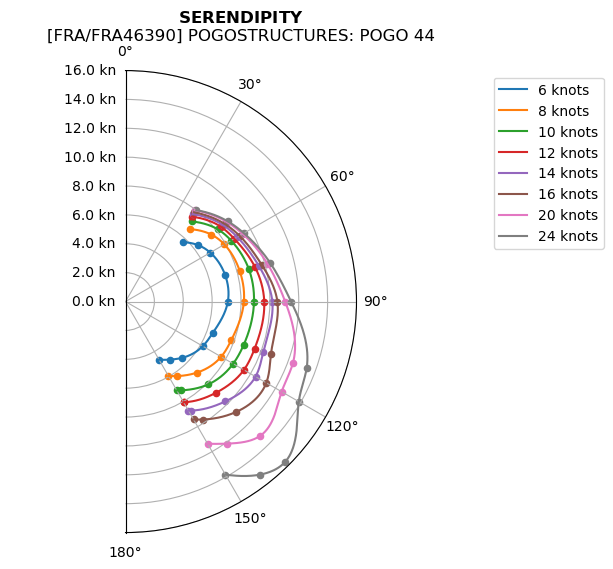

{'sailnumber': 'FRA/FRA46390',
 'country': 'FRA',
 'name': 'SERENDIPITY',
 'rating': {'gph': 526.7,
  'osn': 511.5,
  'triple_offshore': [0.9825, 1.2876, 1.4928],
  'triple_inshore': [0.7539, 1.0233, 1.1982]},
 'boat': {'builder': 'POGOSTRUCTURES',
  'type': 'POGO 44',
  'designer': 'FINOT CONQ',
  'year': 2020,
  'sizes': {'loa': 12.8,
   'beam': 4.5,
   'draft': 3.1,
   'displacement': 6300.0,
   'genoa': 48.89,
   'main': 60.57,
   'spinnaker': 0.0,
   'spinnaker_asym': 148.94,
   'crew': 994.0,
   'wetted_surface': 38.83}},
 'vpp': {'angles': [52, 60, 75, 90, 110, 120, 135, 150],
  'speeds': [6, 8, 10, 12, 14, 16, 20, 24],
  '52': [6.36, 7.54, 8.12, 8.4, 8.59, 8.73, 8.93, 9.01],
  '60': [6.78, 7.91, 8.45, 8.7, 8.94, 9.12, 9.37, 9.47],
  '75': [7.14, 8.19, 8.83, 9.28, 9.56, 9.78, 10.17, 10.37],
  '90': [7.09, 8.2, 8.9, 9.61, 10.17, 10.52, 11.06, 11.47],
  '110': [6.42, 7.8, 8.72, 9.52, 10.16, 10.72, 12.35, 13.36],
  '120': [6.18, 7.65, 8.61, 9.47, 10.4, 11.26, 12.49, 13.86],
  '135'

In [13]:
boats = filter_boats(data,builder="pogo",boat_type="44")
# boats = filter_boats(data,sailnumber=None,name='Vesper')
for i, boat in enumerate(boats):
    if i> 50:
        break
    polar_data = get_polar_data(boat)
 
    plot_half_polar_data_cubicSpline(boat,polar_data)
    plot_half_polar_data_cubicSpline_with_vmg(boat,polar_data)
    # plot_half_polar_data_with_smoothing(boat,polar_data,smoothing_factor=0.2)
    # plot_half_polar_data_with_smooth_cubic_interpolation(boat, polar_data)
    display(boat)


In [14]:
from scipy.interpolate import interp1d
import numpy as np
import math

def get_boat_speed_full_circle(polar_data, TWS, TWA):
    """
    Calculate the most likely boat speed for a given TWS (true wind speed) and TWA (true wind angle),
    handling beat angles for the specific TWS and ensuring linear interpolation for the last segment.
    :param polar_data: Dictionary containing extended polar data.
    :param TWS: True wind speed (in knots).
    :param TWA: True wind angle (in degrees, 0–360°).
    :return: Interpolated boat speed (in knots).
    """
    # Normalize TWA to 0–360°
    TWA = TWA % 360

    # Symmetry: map angles > 180° to their left-half-circle equivalents
    left_half_TWA = TWA if TWA <= 180 else 360 - TWA

    # Extract extended VMG data
    extended_vmg = polar_data.get('extended_vmg', {})
    base_speeds = sorted(extended_vmg.keys())  # Wind speeds (TWS values), sorted

    # Find bounding TWS values
    if TWS < base_speeds[0]:
        lower_tws, upper_tws = base_speeds[0], base_speeds[0]
    elif TWS > base_speeds[-1]:
        lower_tws, upper_tws = base_speeds[-1], base_speeds[-1]
    else:
        lower_tws = max(s for s in base_speeds if s <= TWS)
        upper_tws = min(s for s in base_speeds if s >= TWS)

    # Interpolate within each line
    lower_line = extended_vmg[lower_tws]
    upper_line = extended_vmg[upper_tws]

    # Handle no-go zone: TWA < the minimum angle of the specific line
    min_angle_lower = min(lower_line, key=lambda x: x[0])[0]
    min_angle_upper = min(upper_line, key=lambda x: x[0])[0]
    if left_half_TWA < min_angle_lower and left_half_TWA < min_angle_upper:
        return 0.0

    lower_speed = interpolate_within_line(lower_line, left_half_TWA)
    upper_speed = interpolate_within_line(upper_line, left_half_TWA)

    # Interpolate between the two lines for TWS
    interpolated_speed = np.interp(TWS, [lower_tws, upper_tws], [lower_speed, upper_speed])
    return interpolated_speed

def interpolate_within_line(vmg_line, TWA):
    """
    Interpolate within a single VMG line to find the boat speed for a given TWA,
    using linear interpolation for the last segment and cubic for the rest.
    :param vmg_line: List of (TWA, boat_speed) pairs for a single TWS.
    :param TWA: True wind angle (in degrees).
    :return: Interpolated boat speed (in knots).
    """
    # Extract angles and speeds
    angles = [point[0] for point in vmg_line]
    speeds = [point[1] for point in vmg_line]

    # Identify the last segment
    last_angle = angles[-1]
    last_speed = speeds[-1]

    # Use linear interpolation for the last segment
    if last_angle <= TWA <= 180:
        return math.cos(math.radians(180 - last_angle)) * last_speed
        # return np.interp(TWA, [last_angle, fictitious_angle], [last_speed, fictitious_speed])

    # Use cubic interpolation for the rest
    interp_func = interp1d(angles, speeds, kind='cubic', fill_value="extrapolate")
    return float(interp_func(TWA))


{'sailnumber': 'GBR/CAY007',
 'country': 'GBR',
 'name': 'Vesper',
 'rating': {'gph': 371.7,
  'osn': 362.2,
  'triple_offshore': [1.3871, 1.8176, 2.1726],
  'triple_inshore': [1.0584, 1.4299, 1.7241]},
 'boat': {'builder': 'Persico Marine',
  'type': 'Maxi 72',
  'designer': 'Judel/Vrolijk',
  'year': 2014,
  'sizes': {'loa': 21.946,
   'beam': 5.76,
   'draft': 5.41,
   'displacement': 16473.0,
   'genoa': 132.5,
   'main': 200.41,
   'spinnaker': 0.0,
   'spinnaker_asym': 504.94,
   'crew': 1945.0,
   'wetted_surface': 81.37}},
 'vpp': {'angles': [52, 60, 75, 90, 110, 120, 135, 150],
  'speeds': [6, 8, 10, 12, 14, 16, 20, 24],
  '52': [9.2, 10.64, 11.32, 11.87, 12.34, 12.73, 13.35, 13.69],
  '60': [9.81, 11.14, 11.91, 12.53, 13.04, 13.48, 14.2, 14.71],
  '75': [10.33, 11.67, 12.74, 13.47, 14.11, 14.69, 15.71, 16.51],
  '90': [10.23, 11.6, 12.93, 14.04, 14.89, 15.69, 17.09, 18.15],
  '110': [9.13, 10.96, 12.23, 13.22, 14.59, 16.06, 18.31, 20.01],
  '120': [8.75, 10.73, 12.13, 13.47, 

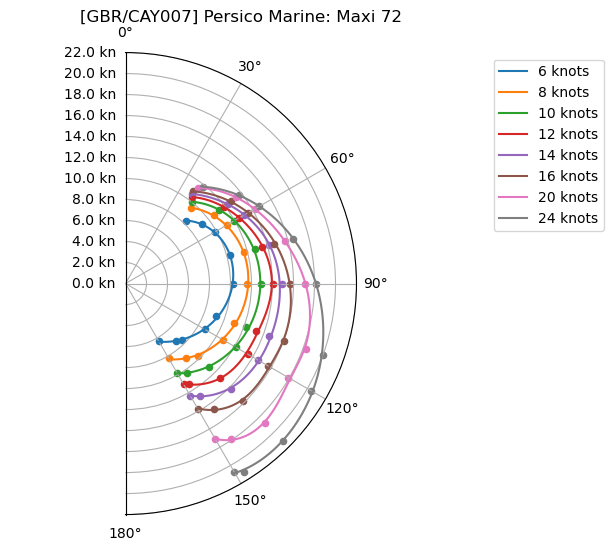

Boat Speed at TWS 12 knots and TWA 25°: 0.00 knots
Boat Speed at TWS 12 knots and TWA 52°: 11.87 knots
Boat Speed at TWS 12 knots and TWA 135°: 12.70 knots
Boat Speed at TWS 12 knots and TWA 150°: 9.59 knots
Boat Speed at TWS 12 knots and TWA 210°: 9.59 knots
Boat Speed at TWS 12 knots and TWA 170°: 9.59 knots
Boat Speed at TWS 12 knots and TWA 180°: 9.59 knots
Boat Speed at TWS 12 knots and TWA 308°: 11.87 knots
Boat Speed at TWS 24 knots and TWA 25°: 0.00 knots
Boat Speed at TWS 24 knots and TWA 52°: 13.69 knots
Boat Speed at TWS 24 knots and TWA 135°: 21.19 knots
Boat Speed at TWS 24 knots and TWA 150°: 17.91 knots
Boat Speed at TWS 24 knots and TWA 210°: 17.91 knots
Boat Speed at TWS 24 knots and TWA 170°: 17.91 knots
Boat Speed at TWS 24 knots and TWA 180°: 17.91 knots
Boat Speed at TWS 24 knots and TWA 308°: 13.69 knots


In [15]:


# Example boat data
example_boat = filter_boats(data,name='Vesper')[0]
display(example_boat)
polar_data = get_polar_data(example_boat)  # Replace with your boat dictionary
plot_half_polar_data_with_smoothing(example_boat,polar_data,smoothing_factor=0.1)
# Query boat speed
TWS = [12,24]  # True Wind Speed in knots
TWA = [25,52, 135, 150, 210, 170, 180, 308] # True Wind Angle in degrees

for tws in TWS:
    for twa in TWA:
        try:
            boat_speed = get_boat_speed_full_circle(polar_data, tws, twa)
            print(f"Boat Speed at TWS {tws} knots and TWA {twa}°: {boat_speed:.2f} knots")
        except ValueError as e:
            print(e)


{'sailnumber': 'GBR/CAY007',
 'country': 'GBR',
 'name': 'Vesper',
 'rating': {'gph': 371.7,
  'osn': 362.2,
  'triple_offshore': [1.3871, 1.8176, 2.1726],
  'triple_inshore': [1.0584, 1.4299, 1.7241]},
 'boat': {'builder': 'Persico Marine',
  'type': 'Maxi 72',
  'designer': 'Judel/Vrolijk',
  'year': 2014,
  'sizes': {'loa': 21.946,
   'beam': 5.76,
   'draft': 5.41,
   'displacement': 16473.0,
   'genoa': 132.5,
   'main': 200.41,
   'spinnaker': 0.0,
   'spinnaker_asym': 504.94,
   'crew': 1945.0,
   'wetted_surface': 81.37}},
 'vpp': {'angles': [52, 60, 75, 90, 110, 120, 135, 150],
  'speeds': [6, 8, 10, 12, 14, 16, 20, 24],
  '52': [9.2, 10.64, 11.32, 11.87, 12.34, 12.73, 13.35, 13.69],
  '60': [9.81, 11.14, 11.91, 12.53, 13.04, 13.48, 14.2, 14.71],
  '75': [10.33, 11.67, 12.74, 13.47, 14.11, 14.69, 15.71, 16.51],
  '90': [10.23, 11.6, 12.93, 14.04, 14.89, 15.69, 17.09, 18.15],
  '110': [9.13, 10.96, 12.23, 13.22, 14.59, 16.06, 18.31, 20.01],
  '120': [8.75, 10.73, 12.13, 13.47, 

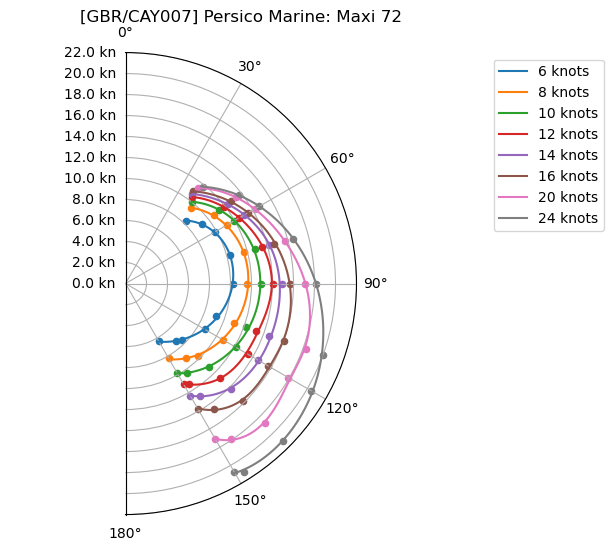

Boat Speed at TWS 12 knots and TWA 25°: 0.00 knots
Boat Speed at TWS 12 knots and TWA 52°: 11.87 knots
Boat Speed at TWS 12 knots and TWA 135°: 12.70 knots
Boat Speed at TWS 12 knots and TWA 150°: 9.59 knots
Boat Speed at TWS 12 knots and TWA 210°: 9.59 knots
Boat Speed at TWS 12 knots and TWA 170°: 9.59 knots
Boat Speed at TWS 12 knots and TWA 180°: 9.59 knots
Boat Speed at TWS 12 knots and TWA 308°: 11.87 knots
Boat Speed at TWS 24 knots and TWA 25°: 0.00 knots
Boat Speed at TWS 24 knots and TWA 52°: 13.69 knots
Boat Speed at TWS 24 knots and TWA 135°: 21.19 knots
Boat Speed at TWS 24 knots and TWA 150°: 17.91 knots
Boat Speed at TWS 24 knots and TWA 210°: 17.91 knots
Boat Speed at TWS 24 knots and TWA 170°: 17.91 knots
Boat Speed at TWS 24 knots and TWA 180°: 17.91 knots
Boat Speed at TWS 24 knots and TWA 308°: 13.69 knots


In [16]:


# Example boat data
example_boat = filter_boats(data,name='Vesper')[0]
display(example_boat)
polar_data = get_polar_data(example_boat)  # Replace with your boat dictionary
plot_half_polar_data_with_smoothing(example_boat,polar_data,smoothing_factor=0.1)
# Query boat speed
TWS = [12,24]  # True Wind Speed in knots
TWA = [25,52, 135, 150, 210, 170, 180, 308] # True Wind Angle in degrees

for tws in TWS:
    for twa in TWA:
        try:
            boat_speed = get_boat_speed_full_circle(polar_data, tws, twa)
            print(f"Boat Speed at TWS {tws} knots and TWA {twa}°: {boat_speed:.2f} knots")
        except ValueError as e:
            print(e)


In [17]:

def plot_polar_with_course_diagram(A, B, polar_data, TWS, TWD=90, method = 'VMC'):
    """
    Plot a polar diagram using TWA conventions and a Cartesian AB course diagram with wind direction.
    """
    # Extract coordinates and calculate the intended COG relative to TWD
    x_A, y_A = A
    x_B, y_B = B
    COG = np.degrees(np.arctan2(x_B - x_A,y_B - y_A)) % 360
    TWA_VMC = (COG - TWD) % 360
    if TWA_VMC > 180:
        TWA_VMC = 360 - TWA_VMC  # Reflect for polar symmetry
    print(f"COG: {COG:.2f}°, TWA_VMC (relative to wind): {TWA_VMC:.2f}°")

    # Interpolate the polar curve for the given TWS
    polar_line = interpolate_polar_curve(polar_data, TWS)
    if polar_line is None:
        print("Error: Unable to interpolate polar curve for the given TWS.")
        return

    # # Find the optimal VMC
    # best_twa, best_sow = find_optimal_vmc(polar_line, TWA_VMC)
    # best_vmc = best_sow * np.cos(np.radians(best_twa - TWA_VMC))
    # print(f"Best VMC at TWA {best_twa:.2f}°: SOG={best_sow:.2f} kn, VMC={best_vmc:.2f} kn")

    # Plot the polar diagram
    # plot_polar_diagram(polar_line, TWA_VMC, best_twa, best_sow, best_vmc, TWS)
    optimal_values = plot_polar_diagram(polar_line, TWA_VMC, TWS)
    # plot_polar_diagram(
    #     polar_line, TWA_VMC, best_twa_port, best_sow_port, best_vmc_port, TWS
    # )
    # Plot the AB course diagram 
    plot_course_diagram_with_tack(A, B, TWD, polar_line, TWA_VMC)

def plot_course_diagram_with_tack(A, B, TWD, polar_line, TWA_VMC):
    """
    Plot the AB course diagram with two optimal heading legs, tack point, and intended course.
    """
    # Extract coordinates for points A and B
    x_A, y_A = A
    x_B, y_B = B

    # Calculate best TWA for port tack
    best_twa_port, best_sow_port = find_optimal_vmc(polar_line, TWA_VMC)

    # Calculate best TWA for starboard tack (mirrored polar curve)
    angles_starboard = (360 - np.array(polar_line[0])) % 360  # Mirror over 0 axis
    speeds_starboard = polar_line[1]  # Symmetrical speeds
    best_twa_starboard, best_sow_starboard = find_optimal_vmc((angles_starboard, speeds_starboard), TWA_VMC)

    # Convert optimal TWAs to true directions
    optimum_heading_port = (TWD + best_twa_port) % 360
    optimum_heading_starboard = (TWD - best_twa_starboard) % 360

    # Convert headings to Cartesian directions
    def heading_to_dx_dy(heading, length=1):
        heading_cartesian = (90 - heading) % 360  # Convert navigational to Cartesian
        dx = length * np.cos(np.radians(heading_cartesian))
        dy = length * np.sin(np.radians(heading_cartesian))
        return dx, dy

    # Calculate direction vectors scaled by SOW
    port_dx, port_dy = heading_to_dx_dy(optimum_heading_port, best_sow_port)
    starboard_dx, starboard_dy = heading_to_dx_dy(optimum_heading_starboard, best_sow_starboard)

    # Calculate intersection point (tack point)
    # Solve for intersection of two lines: one starting at A and the other ending at B
    denominator = port_dx * starboard_dy - starboard_dx * port_dy
    if denominator == 0:
        print("Error: Port and starboard lines are parallel, no tack point found.")
        return

    t = ((y_B - y_A) * starboard_dx - (x_B - x_A) * starboard_dy) / denominator
    x_tack = x_A + t * port_dx
    y_tack = y_A + t * port_dy

    # Create Cartesian plot
    plt.figure(figsize=(8, 8))

    # Plot intended course AB
    plt.plot([x_A, x_B], [y_A, y_B], linestyle="-", color="black", label="Intended Course AB")

    # Plot the two legs
    plt.plot([x_A, x_tack], [y_A, y_tack], linestyle="--", color="blue", label="Leg 1 (Port Tack)")
    plt.plot([x_tack, x_B], [y_tack, y_B], linestyle="--", color="green", label="Leg 2 (Starboard Tack)")

    # Mark the points
    plt.scatter([x_A, x_B, x_tack], [y_A, y_B, y_tack], color="red", label="Points A, B, and Tack")
    plt.text(x_A, y_A, "A", fontsize=12, color="red", ha="right")
    plt.text(x_B, y_B, "B", fontsize=12, color="red", ha="left")
    plt.text(x_tack, y_tack, "Tack", fontsize=12, color="red", ha="center")

    # Add wind direction arrow
    TWD_cartesian = (90 - TWD) % 360
    wind_dx = 5 * np.cos(np.radians(TWD_cartesian))
    wind_dy = 5 * np.sin(np.radians(TWD_cartesian))
    plt.arrow(x_A, y_A, wind_dx, wind_dy, head_width=0.5, head_length=0.7, fc="green", ec="green", label="True Wind Direction")

    # Preserve angles by enforcing equal scaling
    plt.axis("equal")

    # Add grid, labels, and legend
    plt.grid(True)
    plt.title("AB Course Diagram with Tack Point")
    plt.xlabel("Longitude")
    plt.ylabel("Latitude")
    plt.legend(loc="upper right")
    plt.show()


def interpolate_polar_curve(polar_data, TWS):
    """
    Interpolate the polar curve for the given TWS using cubic spline.
    """
    extended_vmg = polar_data.get("extended_vmg", {})
    base_speeds = sorted(extended_vmg.keys())
    if TWS < base_speeds[0] or TWS > base_speeds[-1]:
        print(f"Warning: TWS={TWS} is outside the polar data range ({base_speeds[0]}–{base_speeds[-1]}).")
        return None

    # Find bounding TWS values
    for i in range(len(base_speeds) - 1):
        lower_tws, upper_tws = base_speeds[i], base_speeds[i + 1]
        if lower_tws <= TWS <= upper_tws:
            break

    lower_line = extended_vmg[lower_tws]
    upper_line = extended_vmg[upper_tws]
    angles = [point[0] for point in lower_line]
    lower_speeds = [point[1] for point in lower_line]
    upper_speeds = [point[1] for point in upper_line]

    # Interpolate speeds for the given TWS
    interpolated_speeds = [
        np.interp(TWS, [lower_tws, upper_tws], [lower, upper])
        for lower, upper in zip(lower_speeds, upper_speeds)
    ]

    # Smooth the polar curve using cubic spline
    cubic_spline = CubicSpline(angles, interpolated_speeds, bc_type='natural')
    smooth_angles = np.linspace(min(angles), max(angles), 500)
    smooth_speeds = cubic_spline(smooth_angles)

    return smooth_angles, smooth_speeds


def find_optimal_vmc(polar_line, TWA_VMC=0):
    """
    Find the TWA and speed on the polar curve that maximize the VMC.
    """
    angles, speeds = polar_line
    vmcs = [speed * np.cos(np.radians(angle - TWA_VMC)) for angle, speed in zip(angles, speeds)]
    best_index = np.argmax(vmcs)
    return angles[best_index], speeds[best_index]

def plot_polar_diagram(polar_line, TWA_VMC, TWS):
    """
    Plot the polar diagram with interpolated TWS curve for both port and starboard tacks,
    VMC lines, tangent lines, and legend details. Return optimal values for use in other functions.
    """
    angles_port, speeds_port = polar_line

    # Mirror port tack to get starboard tack
    angles_starboard = (360 - np.array(angles_port)) % 360  # Mirror over 0 axis
    speeds_starboard = speeds_port  # Symmetrical speeds

    # Sort starboard tack angles for plotting
    angles_starboard_sorted = np.sort(angles_starboard)
    speeds_starboard_sorted = [speeds_starboard[i] for i in np.argsort(angles_starboard)]

    # Find VMC-maximizing directions
    best_twa_port, best_sow_port = find_optimal_vmc((angles_port, speeds_port), TWA_VMC)
    best_vmc_port = best_sow_port * np.cos(np.radians(best_twa_port - TWA_VMC))
    best_twa_starboard, best_sow_starboard = find_optimal_vmc((angles_starboard_sorted, speeds_starboard_sorted), TWA_VMC)
    best_vmc_starboard = best_sow_starboard * np.cos(np.radians(best_twa_starboard - TWA_VMC))

    print(f"Port Tack: Best TWA={best_twa_port:.2f}°, SOG={best_sow_port:.2f} kn, VMC={best_vmc_port:.2f} kn")
    print(f"Starboard Tack: Best TWA={best_twa_starboard:.2f}°, SOG={best_sow_starboard:.2f} kn, VMC={best_vmc_starboard:.2f} kn")

    # Create polar plot
    fig, ax = plt.subplots(subplot_kw={'projection': 'polar'}, figsize=(10, 8))
    ax.set_theta_zero_location("N")  # TWA=0 at the top
    ax.set_theta_direction(-1)       # Angles increase clockwise

    # Plot port tack polar curve
    ax.plot(np.radians(angles_port), speeds_port, label="Port Tack Polar Curve", color="blue")

    # Plot starboard tack polar curve
    ax.plot(np.radians(angles_starboard_sorted), speeds_starboard_sorted, label="Starboard Tack Polar Curve", color="green")

    # Plot VMC lines and tangent lines
    def plot_vmc_and_tangent(ax, TWA_VMC, best_twa, best_sow, best_vmc, color, label_prefix):
        # VMC Line
        vmc_line_length = best_sow * np.cos(np.radians(best_twa - TWA_VMC))
        ax.plot([0, np.radians(TWA_VMC)], [0, vmc_line_length], linestyle="--", color=color,
                label=f"{label_prefix} VMC={best_vmc:.2f} kn at TWA {TWA_VMC:.2f}°")

        # Tangent Line
        ax.plot([np.radians(best_twa), np.radians(TWA_VMC)], [best_sow, vmc_line_length],
                linestyle=":", color=color, label=f"{label_prefix} Optimal Heading (TWA={best_twa:.2f}°)")

    # Port Tack
    plot_vmc_and_tangent(ax, TWA_VMC, best_twa_port, best_sow_port, best_vmc_port, "orange", "Port Tack")

    # Starboard Tack
    plot_vmc_and_tangent(ax, TWA_VMC, best_twa_starboard, best_sow_starboard, best_vmc_starboard, "red", "Starboard Tack")

    # Highlight optimal points
    ax.scatter(np.radians(best_twa_port), best_sow_port, color="darkblue", label="Optimal Point (Port Tack)")
    ax.scatter(np.radians(best_twa_starboard), best_sow_starboard, color="darkgreen", label="Optimal Point (Starboard Tack)")

    # Add title and legend
    ax.set_title(f"Sailboat Polar Diagram (TWS={TWS} kn)\nTWA=0 at Top")
    ax.legend(loc="upper right", bbox_to_anchor=(1.5, 1.0))  # Move legend outside the plot

    # Configure radial ticks and labels
    ax.set_rmax(max(speeds_port) + 2)
    ax.set_rticks(np.arange(0, max(speeds_port) + 2, 2))
    ax.set_rlabel_position(90)

    plt.show()

    # Return the optimal values
    return best_twa_port, best_sow_port, best_vmc_port, best_twa_starboard, best_sow_starboard, best_vmc_starboard


In [18]:
# Define start and end points
A = (0, 8)
B = (16, 0)

# Define wind conditions
TWS = 15  # True Wind Speed in knots
TWD = 90  # True Wind Direction (from East)

# Call the function
# plot_polar_with_vmc_and_tangent(A, B, polar_data, TWS, TWD)
# plot_polar_with_vmc_and_tangent(A, B, polar_data, TWS, TWD)



{'sailnumber': 'GBR/CAY007',
 'country': 'GBR',
 'name': 'Vesper',
 'rating': {'gph': 371.7,
  'osn': 362.2,
  'triple_offshore': [1.3871, 1.8176, 2.1726],
  'triple_inshore': [1.0584, 1.4299, 1.7241]},
 'boat': {'builder': 'Persico Marine',
  'type': 'Maxi 72',
  'designer': 'Judel/Vrolijk',
  'year': 2014,
  'sizes': {'loa': 21.946,
   'beam': 5.76,
   'draft': 5.41,
   'displacement': 16473.0,
   'genoa': 132.5,
   'main': 200.41,
   'spinnaker': 0.0,
   'spinnaker_asym': 504.94,
   'crew': 1945.0,
   'wetted_surface': 81.37}},
 'vpp': {'angles': [52, 60, 75, 90, 110, 120, 135, 150],
  'speeds': [6, 8, 10, 12, 14, 16, 20, 24],
  '52': [9.2, 10.64, 11.32, 11.87, 12.34, 12.73, 13.35, 13.69],
  '60': [9.81, 11.14, 11.91, 12.53, 13.04, 13.48, 14.2, 14.71],
  '75': [10.33, 11.67, 12.74, 13.47, 14.11, 14.69, 15.71, 16.51],
  '90': [10.23, 11.6, 12.93, 14.04, 14.89, 15.69, 17.09, 18.15],
  '110': [9.13, 10.96, 12.23, 13.22, 14.59, 16.06, 18.31, 20.01],
  '120': [8.75, 10.73, 12.13, 13.47, 

COG: 116.57°, TWA_VMC (relative to wind): 26.57°
Port Tack: Best TWA=51.69°, SOG=12.50 kn, VMC=11.32 kn
Starboard Tack: Best TWA=323.30°, SOG=10.76 kn, VMC=4.84 kn


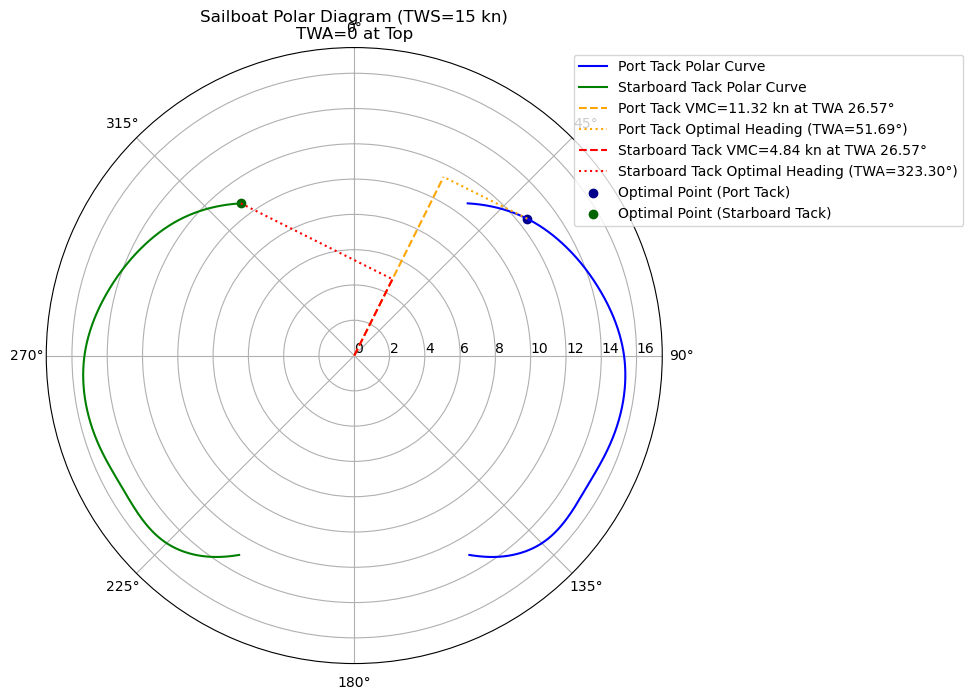

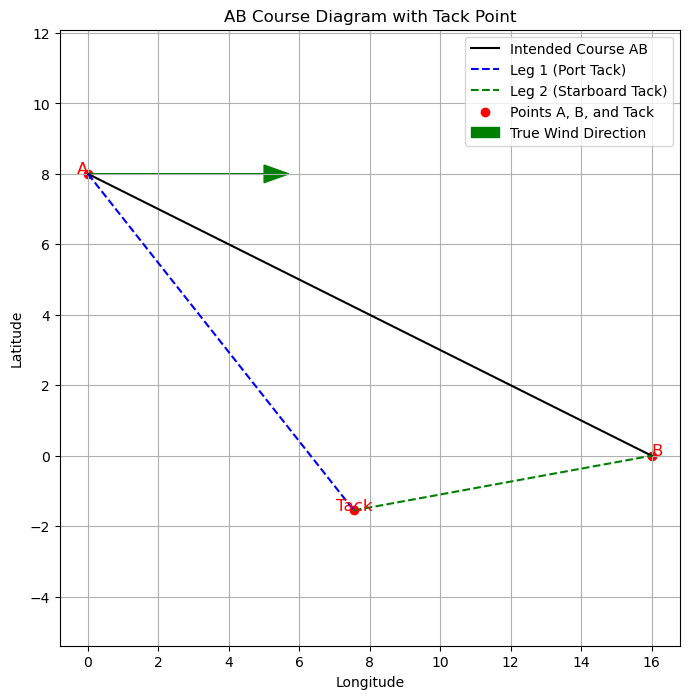

In [19]:
# Example boat data
example_boat = filter_boats(data,name='Vesper')[0]
display(example_boat)
polar_data = get_polar_data(example_boat)  # Replace with your boat dictionary


# Call the function
plot_polar_with_course_diagram(A, B, polar_data, TWS, TWD, method='VMC')

In [20]:
from src.sailutils import *


In [21]:
boat = example_boat
polar_line = interpolate_polar_curve(get_polar_data(example_boat),15)
# angles_full_rad, speeds_full, bearings_full_rad = preprocess_polar_data(polar_line,90)
TWS = 15
TWD = 145
A=(0,0)
B=(10,0)

In [22]:
delta_x = B[0] - A[0]  # Northing difference
delta_y = B[1] - A[1]  # Easting difference
distance_AB = np.sqrt(delta_x**2 + delta_y**2)
COG = (np.degrees(np.arctan2(delta_y, delta_x)) + 360) % 360  # Course over ground
TWA_VMC = (COG - TWD + 360) % 360
vars = {
            "boat": boat,
            "polar_data": polar_data,
            "A": A,
            "B": B,
            "TWD": TWD,
            "TWS": TWS,
            "TWA_VMC": TWA_VMC,
            "distance_nm": distance_AB,
        }
print(TWD)

145


In [23]:
res = preprocess_polar_data(polar_line,vars['TWD'])
print(np.degrees(res['bearings_full_rad'][0]))
pol = {"polar_line": polar_line, 
        "angles_full_rad": res["angles_full_rad"],
        'speeds_full':  res["speeds_full"],
        "bearings_full_rad": res["bearings_full_rad"]
        }
print(np.degrees(pol['angles_full_rad'][0]),np.degrees(pol['bearings_full_rad'][0]))

181.7
36.7 181.7


In [24]:
vmc_data =  calc_vmc_results(pol, vars['A'], vars['B'], vars['TWA_VMC'])
display(vmc_data)

1
-87.21530841156488


{'leg1': {'optimal_twa_deg': np.float64(225.43967935871746),
  'optimal_speed': np.float64(15.062908717364426),
  'optimal_vmc_deg': np.float64(848.7545034319545),
  'optimal_bearing_rad': np.float64(0.1822067776621098)},
 'leg2': {'optimal_leg2_angle_rad': np.float64(3.75237394809633),
  'optimal_leg2_speed': np.float64(13.932684868081198),
  'intersection_point': (np.float64(13.571904166097994),
   np.float64(0.854166629992758)),
  'total_elapsed_time': np.float64(1.1663945906939894),
  'distance_leg1': np.float64(13.598756683077363),
  'distance_leg2': np.float64(3.6726148727550227),
  'optimal_vmc_deg': np.float64(798.2840374142672)},
 'elapsed_time': np.float64(1.1663945906939894),
 'distances': {'leg1': np.float64(13.598756683077363),
  'leg2': np.float64(3.6726148727550227)}}

/home/farsipal/projects/GITHUB/sail-tactics/src/sailutils.py:515: UserWarning: Legend does not support handles for Annotation instances.
See: https://matplotlib.org/stable/tutorials/intermediate/legend_guide.html#implementing-a-custom-legend-handler
  ax.legend(loc="upper center", bbox_to_anchor=(0.5, -0.1), ncol=1, fontsize=10)  # Move legend below the plot


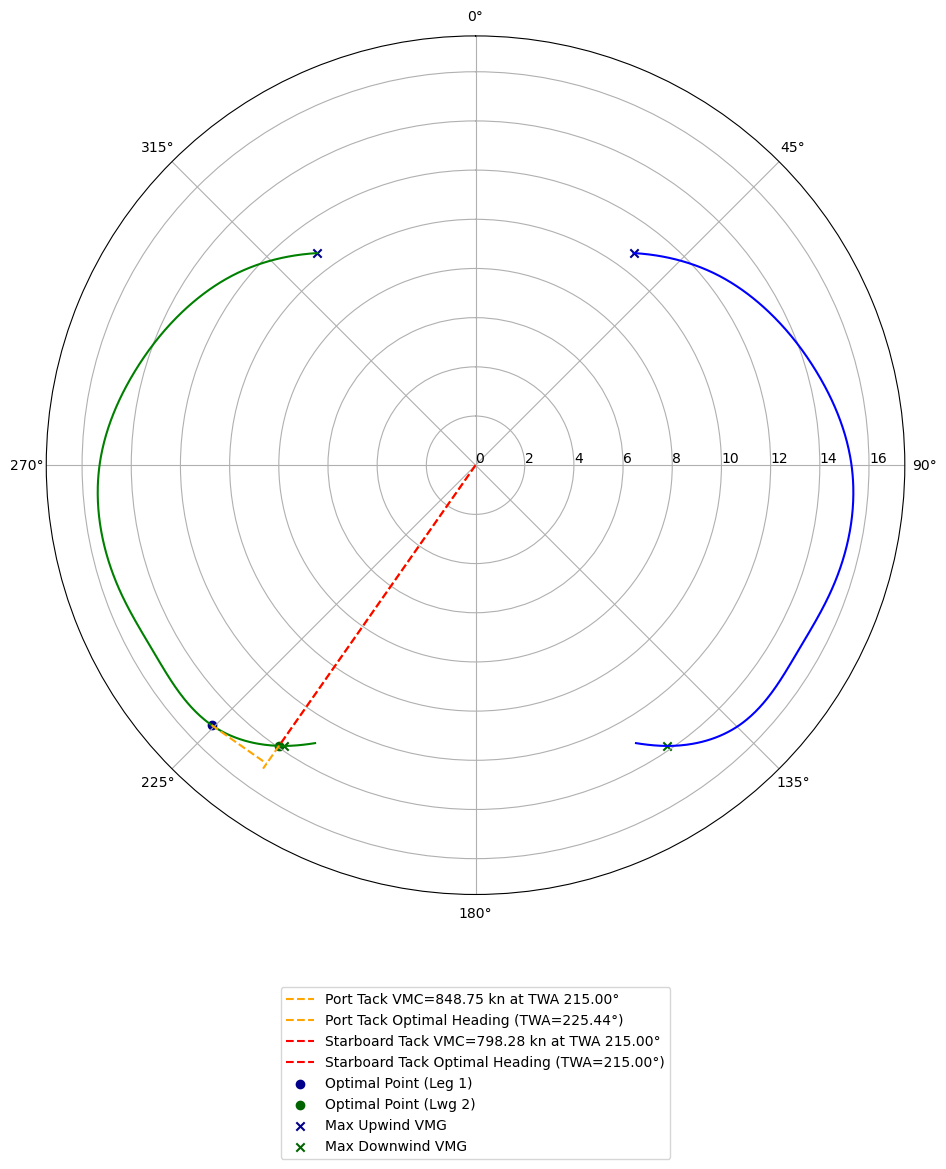

In [25]:
plot_polar_diagram(
            pol['polar_line'],
            vars["TWA_VMC"],
            vars["TWS"],
            vmc_data
        )